In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from poisson_glm_granger import compute_granger_causality, permutation_test
from joblib import Parallel, delayed


Source 0 -> Target 0: Optimal window = 1, CV score = -0.6456
Source 1 -> Target 0: Optimal window = 1, CV score = -0.6772
Source 2 -> Target 0: Optimal window = 1, CV score = -0.6767
Source 0 -> Target 1: Optimal window = 1, CV score = -0.5661
Source 1 -> Target 1: Optimal window = 1, CV score = -0.6905
Source 2 -> Target 1: Optimal window = 9, CV score = -0.6928
Source 0 -> Target 2: Optimal window = 2, CV score = -0.3944
Source 1 -> Target 2: Optimal window = 1, CV score = -0.3047
Source 2 -> Target 2: Optimal window = 3, CV score = -0.4154


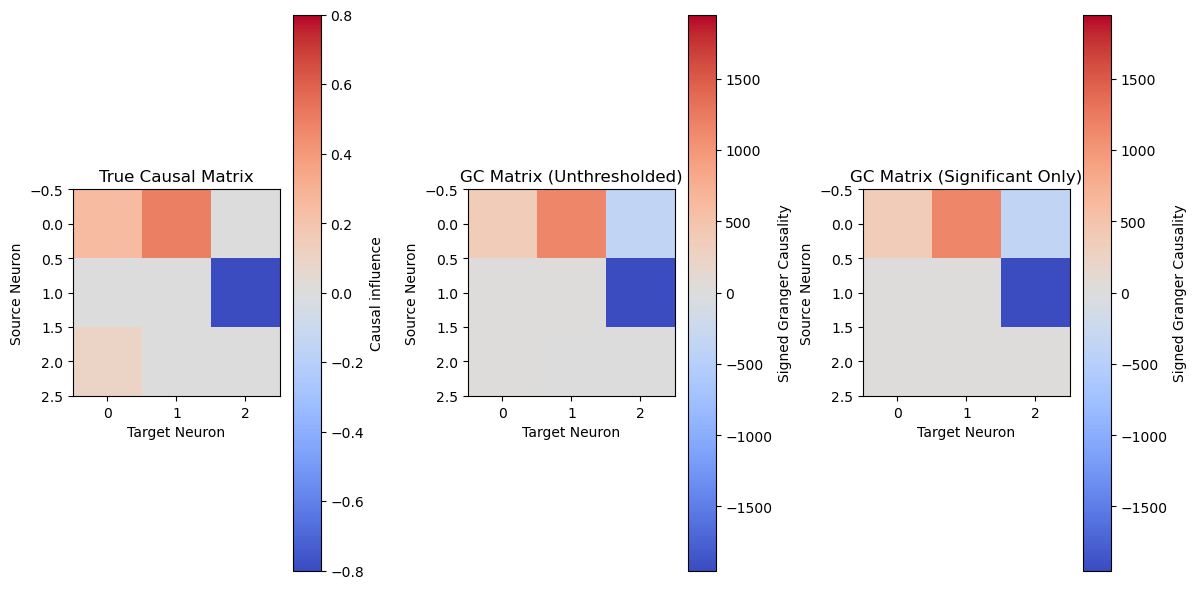

Granger Causality Matrix (Unthresholded):
[[ 3.58956977e+02  1.13621233e+03 -3.56112271e+02]
 [ 2.03076697e-03  2.42037656e-01 -1.95018953e+03]
 [ 1.49300288e+01 -3.88362842e+00 -3.22467566e+00]]

Significant Granger Causality Matrix:
[[  358.95697693  1136.21232706  -356.1122709 ]
 [    0.             0.         -1950.18953122]
 [   14.93002877     0.             0.        ]]


In [2]:
# Function to generate synthetic spike train data for trials
def generate_synthetic_spike_data_trials(neurons, trials, time_steps, causal_matrix, base_rate=0.01, noise_level=0.1):
    data = np.zeros((neurons, trials, time_steps))
    for trial in range(trials):
        for t in range(1, time_steps):
            for i in range(neurons):
                firing_rate = base_rate
                for j in range(neurons):
                    if causal_matrix[j, i] != 0:
                        firing_rate += causal_matrix[j, i] * data[j, trial, t - 1]
                firing_prob = max(0, min(1, firing_rate + np.random.normal(0, noise_level)))
                data[i, trial, t] = 1 if np.random.rand() < firing_prob else 0
    return data

# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, 0.0]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.1
)

# Analyze Granger causality with cross-validation
best_windows, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    window_range=(1, 20), 
    folds=10,
    gc_type='conditional'
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    gc_matrix,
    signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4,
    gc_type='conditional'
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)

In [ ]:
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    gc_matrix,
    signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4,
    gc_type='partial'
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)